In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neptune
from models import create_compound_model_from_info, create_pytorch_model_from_info, MultiHead
import json
import torch
import os
from utils_neptune import check_if_path_in_struc, get_sub_struc_from_path
from collections import defaultdict

from lifelines import KaplanMeierFitter, CoxPHFitter


NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='
# data_dir= '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_finetune_optimization/April_30_Finetune_Data'
# local_dir = os.path.expanduser('~/Desktop/saved_models')

data_dir= '/app/finetune_data'
output_dir = '/app/mz_embed_engine/output'
local_dir = os.path.expanduser('~/saved_models')
run_id = 'RCC-2925'

In [4]:
data_dir = '/Users/jonaheaton/DATA3'

## Load the Survival Model

In [2]:
task_id = 'Optimized_NIVO-OS_finetune'
head_key = 'NIVO OS'

model_dir = f'{local_dir}/{run_id}/{task_id}'
components_dir = f'{local_dir}/{run_id}/{task_id}/components'
os.makedirs(components_dir, exist_ok=True)
model_files = os.listdir(components_dir)

if (len(model_files) < 4):

    run = neptune.init_run(project='revivemed/RCC',
        api_token= NEPTUNE_API_TOKEN,
        with_id=run_id,
        mode="read-only")   
    run_struc= run.get_structure()

    original_kwargs=run[task_id+'/original_kwargs'].fetch()
    json.dump(original_kwargs,open(f'{components_dir}/original_kwargs.json','w'),indent=4)
    substruc = get_sub_struc_from_path(run_struc,f'{task_id}/models')
    for key in substruc.keys():
        if 'info' in key:
            run[f'{task_id}/models/{key}'].download(f'{components_dir}/{key}.json')
        elif 'state' in key:
            run[f'{task_id}/models/{key}'].download(f'{components_dir}/{key}.pt')

    run.stop()
    model_files = os.listdir(components_dir)


encoder_info = None
head_info = None
encoder_state = None
head_state = None
original_kwargs = None

for f in model_files:
    if ('encoder' in f):
        if 'info' in f:
            encoder_info = json.load(open(f'{components_dir}/{f}'))
        elif 'state' in f:
            encoder_state = torch.load(f'{components_dir}/{f}')
    if (head_key in f):
        if 'info' in f:
            head_info = json.load(open(f'{components_dir}/{f}'))
            # head_name = f.replace('_info.json', '')
        elif 'state' in f:
            head_state = torch.load(f'{components_dir}/{f}')
    if 'original_kwargs' in f:
        original_kwargs = json.load(open(f'{components_dir}/{f}'))
            
if (encoder_info is not None) and (head_info is not None):            
    model = create_compound_model_from_info(encoder_info=encoder_info, 
                                            head_info= head_info,
                                            encoder_state_dict=encoder_state,
                                            head_state_dict=head_state)
    
    params = {}
    params['encoder dropout_rate'] = encoder_info['dropout_rate']
    params['head name'] = head_info['name']
    params['head layers']= head_info['architecture']['num_hidden_layers']
    if (original_kwargs is not None) and ('train_kwargs' in original_kwargs):
        params['head weight'] = head_info['weight']*original_kwargs['train_kwargs']['head_weight']
        params['num auxillary heads'] = len(original_kwargs['head_kwargs_dict']) -1
        
        if 'adversarial_head_kwargs_dict' in original_kwargs:
            params['num adversarial heads'] = len(original_kwargs['adversarial_head_kwargs_dict'])
        else:
            params['num adversarial heads'] = 0
        params['adversary weight'] = original_kwargs['train_kwargs']['adversary_weight']
        params['adversarial_start_epoch'] = original_kwargs['train_kwargs']['adversarial_start_epoch']
        if params['adversary weight'] == 0 or params['num adversarial heads'] == 0:
            params['adversary weight'] = 0
            params['num adversarial heads'] = 0
            params['adversarial_start_epoch'] = 0
        
        params['encoder weight'] = original_kwargs['train_kwargs']['encoder_weight']
        params['learning rate'] = original_kwargs['train_kwargs']['learning_rate']
        params['l1_reg_weight'] = original_kwargs['train_kwargs']['l1_reg_weight']
        params['l2_reg_weight'] = original_kwargs['train_kwargs']['l2_reg_weight']
        params['noise_factor'] = original_kwargs['train_kwargs']['noise_factor']
        params['num_epochs'] = original_kwargs['train_kwargs']['num_epochs']
        params['weight_decay'] = original_kwargs['train_kwargs']['weight_decay']

    model.save_info(model_dir, f'VAE {head_key} info.json')
    model.save_state_to_path(model_dir, f'VAE {head_key} state.pt')

    skmodel = create_pytorch_model_from_info(full_model=model)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2925


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2925/metadata
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2925/metadata


## Load the data

In [5]:
X_test_data = pd.read_csv(f'{data_dir}/X_finetune_test.csv',index_col=0)
y_test_data = pd.read_csv(f'{data_dir}/y_finetune_test.csv',index_col=0)
X_trainval_data = pd.read_csv(f'{data_dir}/X_finetune_trainval.csv',index_col=0)
y_trainval_data = pd.read_csv(f'{data_dir}/y_finetune_trainval.csv',index_col=0)

In [6]:
# calculate the predicted hazards and predicted surivals

y_test_data['predicted hazard'] = skmodel.predict(X_test_data.to_numpy()).flatten()
y_trainval_data['predicted hazard'] = skmodel.predict(X_trainval_data.to_numpy()).flatten()

## Determine the two-level threshold

In [7]:
# generalized function to run grid search with custom objective
def prep_surv_y(survival_column, event_column):
    """
    Function for formatting survival data as input to sksurv models.
    Args:
        survival_column: list of survival times
        event_column: list of event indicators (0 for censored, 1 for event)
    """
    surv_y = np.array([(event_column.iloc[i], survival_column.iloc[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    # surv_y = np.array([(event_column[i], survival_column[i]) for i in range(len(survival_column))], dtype=[('status', bool), ('time', float)])
    return surv_y

def create_data_dict(data_dir,set_name,os_col,event_col,data_dict=None):
    if data_dict is None:
        data_dict = {}
    X_path = f'{data_dir}/X_finetune_{set_name}.csv'
    y_path = f'{data_dir}/y_finetune_{set_name}.csv'
    X = pd.read_csv(X_path, index_col=0)
    y = pd.read_csv(y_path, index_col=0)
    not_nan = ~y[os_col].isna()
    data_dict[set_name] = {"X": X.loc[not_nan],
                           "y": prep_surv_y(y.loc[not_nan,os_col], y.loc[not_nan,event_col]),
                           'os_col':os_col,
                           'event_col':event_col,
                           'X_file':X_path,
                           'y_file':y_path}
    return data_dict


def get_best_cph_threshold(model_trained, new_data,min_class_size=5):
    """
    Identify the threshold that maximizes C-index between classes where p remains significant. Note: this does NOT account for clinical covariates
    Args:
        model_trained: trained CoxPH model
        new_data: dict with new data (transformed and scaled) and survival data
        feats: list of features to use
    Returns:
        dictionary with p-value, coefficient, concordance index, and number of samples in each class
    """

    tmp = pd.DataFrame(new_data["y"]).set_axis(['Event', 'Survival'], axis=1)

    # predict survival
    # if type(model_trained) == xgb.core.Booster:
    #     predicted_surv = model_trained.predict(new_data["xgb_x"])
    # else: 
    predicted_surv = model_trained.predict(new_data["X"].to_numpy())

    # identify threshold maximizing c-index between classes where p remains significant
    thresh_summary = {}
    for th in np.unique(predicted_surv):
        # predict classes
        pred_ev = (predicted_surv > th)
        if (sum(pred_ev) < min_class_size) or (sum(~pred_ev) < min_class_size):
            continue

        mod_d = tmp.copy()
        mod_d['pred'] = pred_ev

        if any(mod_d['pred']) & any(~mod_d['pred']):  # only look if there's at least 1 of both classes
        
            try:
                cph = CoxPHFitter()
                cph.fit(mod_d, 'Survival', 'Event', formula='pred')
                thresh_summary[th] = {'p': cph.summary.loc['pred']['p'], 'coef': cph.summary.loc['pred']['coef'], 'c_ind': cph.concordance_index_, "n_lo": sum(pred_ev==0), "n_hi": sum(pred_ev==1)}
            except:
                thresh_summary[th] = {'p': np.nan, 'coef': np.nan, 'c_ind': np.nan, "n_lo": sum(pred_ev==0), "n_hi": sum(pred_ev==1)}

            # calculate median survival of each class
            kmf = KaplanMeierFitter()
            for i in [False, True]:
                lab_map = {True: "lo", False: "hi"}
                kmf.fit(mod_d.loc[mod_d['pred']==i, 'Survival'], mod_d.loc[mod_d['pred']==i, 'Event'], label=f"class_{i}")
                thresh_summary[th][f"io_{lab_map[i]}_mst"] = kmf.median_survival_time_

    thresh_df = pd.DataFrame(thresh_summary).T
    thresh_df = thresh_df.loc[thresh_df['io_hi_mst'] > thresh_df['io_lo_mst']].dropna()  # drop any where hi class has lower median survival
    if any(thresh_df['p']<0.05):
        best_thresh = thresh_df.loc[thresh_df['p']<0.05].sort_values('c_ind', ascending=False).iloc[0].name
    else:
        best_thresh = 0
    return best_thresh, thresh_df



In [8]:
data_dict =create_data_dict(data_dir,'trainval','NIVO OS','OS_Event')
# data_dict =create_data_dict(data_dir,'test','OS','OS_Event',data_dict)

In [7]:
data_dict['trainval']['y'].shape

(313,)

In [8]:
best_thresh,thresh_df = get_best_cph_threshold(skmodel, data_dict['trainval'], min_class_size=20)


/usr/local/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column pred have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'pred'].var())
>>> print(df.loc[~events, 'pred'].var())

A very low variance means that the column pred completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.245. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

 

In [ ]:
thresh_df

,p,coef,c_ind,n_lo,n_hi,io_hi_mst,io_lo_mst
-19.573648,0.9909,18.127896,0.550746,[20],[293],inf,23.162218
-19.401531,0.990677,18.141931,0.553318,[21],[292],inf,23.162218
-19.390272,0.990393,18.134208,0.555843,[22],[291],inf,22.86653
-19.226923,0.990181,18.148796,0.558414,[23],[290],inf,22.86653
-19.123745,0.990079,18.181314,0.560939,[24],[289],inf,22.505133
...,...,...,...,...,...,...,...
2.066435,0.0,4.692085,0.579643,[289],[24],27.893224,2.6612
2.067636,0.0,4.60301,0.576592,[290],[23],27.893224,2.562628
2.103300,0.0,4.462088,0.573202,[291],[22],27.893224,2.6612
2.118107,0.0,4.41708,0.570174,[292],[21],27.827515,2.4641


In [9]:
best_thresh = -6.2614393

In [ ]:
print(best_thresh)

-6.2614393


In [10]:
y_trainval_data['class'] = 'IM+'
y_trainval_data.loc[y_trainval_data['predicted hazard'] >= best_thresh, 'class'] = 'IM-'
y_trainval_data['class'].value_counts()

class
IM-    309
IM+    283
Name: count, dtype: int64

In [11]:
# Class selection within the NIVO treated patients
print('Class selection within NIVO Discovery')
y_trainval_data[y_trainval_data['Treatment is NIVO']==1]['class'].value_counts()

Class selection within NIVO Discovery


class
IM+    160
IM-    153
Name: count, dtype: int64

In [12]:
var_cols = ['Sex', 'Age_Group', 'Region', 'IMDC', 'Prior_2', 'class']

plot_order = [
    ('Age_Group', ' >75'),
    ('Age_Group', '65-75'),
    ('Age_Group', '<65'),
    ('Sex', 'F'),
    ('Sex', 'M'),
    ('Prior_2', True),
    ('Prior_2', False),
    ('Region', 'WESTERN EUROPE'),
    ('Region', 'US/CANADA'),
    ('Region', 'REST OF WORLD'),
    ('IMDC', 'POOR'),
    ('IMDC', 'INTERMEDIATE'),
    ('IMDC', 'FAVORABLE'),
    ('Total', 'NIVOLUMAB')]

In [13]:
survival_col = 'OS'
event_col = 'OS_Event'
cph_df_cleaned = y_test_data.copy()

cph_df_cleaned['class'] = 'IM+'
cph_df_cleaned.loc[cph_df_cleaned['predicted hazard'] >= best_thresh, 'class'] = 'IM-'

In [14]:
cph_df_cleaned['class'].value_counts()

class
IM-    87
IM+    62
Name: count, dtype: int64

OS OS_Event
After dropping na from Sex, n= 149
After dropping na from Age_Group, n= 149
After dropping na from Region, n= 149
After dropping na from IMDC, n= 149
After dropping na from Prior_2, n= 149
After dropping na from class, n= 149
After dropping na from Sex, n= 62
After dropping na from Age_Group, n= 62


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Treatment[T.NIVOLUMAB] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_Event'].astype(bool)
>>> print(df.loc[events, 'Treatment[T.NIVOLUMAB]'].var())
>>> print(df.loc[~events, 'Treatment[T.NIVOLUMAB]'].var())

A very low variance means that the column Treatment[T.NIVOLUMAB] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column Treatment[T.NIVOLUMAB] has high sample correlation with the 

After dropping na from Region, n= 62
After dropping na from IMDC, n= 62
After dropping na from Prior_2, n= 62
After dropping na from class, n= 62
After dropping na from Sex, n= 87
After dropping na from Age_Group, n= 87
After dropping na from Region, n= 87
After dropping na from IMDC, n= 87
After dropping na from Prior_2, n= 87
After dropping na from class, n= 87


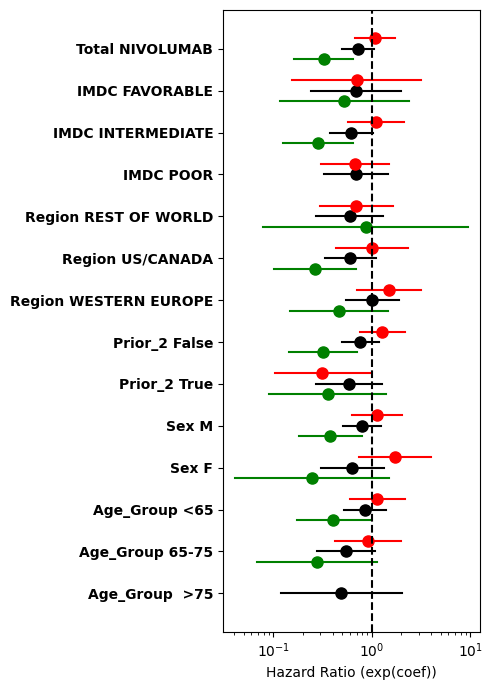

In [15]:
col_to_use = 'black'

# survival_col = 'OS'
print(survival_col, event_col)

all_summary_dl = []
for filter_option in ["All", "IM+", "IM-"]:
    all_summary_d = {}
    cph_df_filt = cph_df_cleaned.copy()
    if filter_option != "All":
        cph_df_filt = cph_df_filt.loc[cph_df_filt['class']==filter_option].copy()
    for col in var_cols:
        cph_df_sub = cph_df_filt.copy()
        cph_df_sub = cph_df_sub.dropna(subset=[col])
        print(f"After dropping na from {col}, n=", cph_df_sub.shape[0])
        cph_df_sub[col] = pd.Categorical(cph_df_sub[col])
        # relevel categories so that each one can be reference
        for cat_val in cph_df_sub[col].cat.categories:
            cph_df_sub_sub = cph_df_sub.loc[cph_df_sub[col]==cat_val]
            cph = CoxPHFitter()
            cph_formula = 'Treatment'#*'+col # paper analysis
            all_formula = 'Treatment'
            try:
                x=cph.fit(cph_df_sub_sub, duration_col=survival_col, event_col=event_col, formula=cph_formula, show_progress=False)
                summary_table = x.summary.to_dict(orient="index")
                # summary_table = pd.DataFrame(summary_table.loc["Treatment[T.NIVOLUMAB]",:]).T
                all_summary_d[(col, cat_val)] = summary_table["Treatment[T.NIVOLUMAB]"]
                all_summary_d[(col, cat_val)]['NIVO n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['Treatment']=='NIVOLUMAB') & (cph_df_sub_sub[col]==cat_val)].shape[0]
                all_summary_d[(col, cat_val)]['EVERO n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['Treatment']=='EVEROLIMUS') & (cph_df_sub_sub[col]==cat_val)].shape[0]
                all_summary_d[(col, cat_val)]['class'] = filter_option
            except:
                all_summary_d[(col, cat_val)] = {"coef": np.nan, "exp(coef)": np.nan, "se(coef)": np.nan, "coef lower 95%": np.nan, "coef upper 95%": np.nan, "exp(coef) lower 95%": np.nan, "exp(coef) upper 95%": np.nan, "z": np.nan, "p": np.nan, "-log2(p)": np.nan, "class": filter_option}
                all_summary_d[(col, cat_val)]['NIVO n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['Treatment']=='NIVOLUMAB') & (cph_df_sub_sub[col]==cat_val)].shape[0]
                all_summary_d[(col, cat_val)]['EVERO n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['Treatment']=='EVEROLIMUS') & (cph_df_sub_sub[col]==cat_val)].shape[0]
            # all_summary += [summary_table]
    cph_all = CoxPHFitter()
    x_all = cph_all.fit(cph_df_filt, duration_col=survival_col, event_col=event_col, formula=all_formula, show_progress=False)
    summary_table = x_all.summary.to_dict(orient="index")
    all_summary_d[('Total', 'NIVOLUMAB')] = summary_table["Treatment[T.NIVOLUMAB]"]
    all_summary_d[('Total', 'NIVOLUMAB')]['NIVO n'] = cph_df_filt.loc[(cph_df_filt['Treatment']=='NIVOLUMAB')].shape[0]
    all_summary_d[('Total', 'NIVOLUMAB')]['EVERO n'] = cph_df_filt.loc[(cph_df_filt['Treatment']=='EVEROLIMUS')].shape[0]
    all_summary_d[('Total', 'NIVOLUMAB')]['class'] = filter_option


    plot_table = pd.DataFrame.from_dict(all_summary_d, orient="index")
    all_summary_dl += [plot_table]

plt.figure(figsize=(5, 7))

col_dict = {"IM+": "green", "IM-": "red", "All": "black"}
offset_dict = {"IM+": -0.25, "IM-": 0.25, "All": 0}

plot_table = pd.concat(all_summary_dl)
plot_table = plot_table.loc[['class' not in i for i in plot_table.index]]
n_ind = dict(zip(plot_order, np.arange(len(plot_table.index.unique()))))
for index, row in plot_table.iterrows():
    index_name = f'{index[0]} {index[1]}'
    if 'class' not in index_name:
        # if any confidence interval is Inf, do not plot it
        if row['exp(coef) lower 95%'] > 0 and row['exp(coef) upper 95%'] != np.inf:
            # if any row has NIVO n <5 or EVERO n <5, do not plot it
            if row['NIVO n'] >= 4 and row['EVERO n'] >= 4:
                # offset the points slightly to avoid overlap
                plt.plot(row['exp(coef)'], [n_ind[index]+offset_dict[row['class']]], 'o', color=col_dict[row['class']], markersize=8)
                plt.plot([row['exp(coef) lower 95%'], row['exp(coef) upper 95%']], [n_ind[index]+offset_dict[row['class']], n_ind[index]+offset_dict[row['class']]], marker='', markersize=8, linestyle='-', color=col_dict[row['class']])
        else:
            # plot a horizontal line at 1
            plt.plot([1, 1], [n_ind[index]+offset_dict[row['class']], n_ind[index]+offset_dict[row['class']]], marker='', markersize=8, linestyle='-', color=col_dict[row['class']])


# limit x axis to 0.25 - 4
# plt.xlim(0.1, 3)

# add vertical dashed line at 1
plt.axvline(x=1, linestyle='--', color='black')
# plt.yticks(range(len(summary_table)), summary_table.index)
plt.xscale('log')  # Use log scale for better visualization
plt.xlabel('Hazard Ratio (exp(coef))')
# plt.xticks([0.01, 0.1, 0.25, 0.5, 1, 2.5, 5], [0.01, 0.1, 0.25, 0.5, 1, 2.5, 5])

# # Adjust axis limits
# xmin, xmax, ymin, ymax = plt.axis()
# plt.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])  # Adjust the offset as needed
plt.yticks(list(n_ind.values()), [f'{index[0]} {index[1]}' for index in n_ind.keys()])
plt.yticks(fontweight='bold')
plt.tight_layout()

# # format plot_table to 3 decimal places
ptf = plot_table.round(3)
# reverse order of rows
ptf = ptf.iloc[::-1]
ptf['HR (95% CI)'] = ptf.apply(lambda x: f"{x['exp(coef)']} ({x['exp(coef) lower 95%']}, {x['exp(coef) upper 95%']})", axis=1)
# ptf[['HR (95% CI)', 'p', 'NIVO n', 'EVERO n', 'class']]
ptf_d = ptf[['HR (95% CI)', 'p', 'NIVO n', 'EVERO n', 'class']].pivot(columns='class').to_dict(orient="index")
# for k,v in ptf.items():
#     # add text of v to plot
#     plt.text(10, n_ind[k], f"{v[('HR (95% CI)', 'All')]}")

# ptf[['HR (95% CI)', 'p', 'NIVO n', 'EVERO n', 'class']].pivot(columns='class').iloc[::-1][[('HR (95% CI)', 'All'), ('p', 'All'), ('NIVO n', 'All'), ('EVERO n', 'All'), ('HR (95% CI)', 'IM+'), ('p', 'IM+'), ('NIVO n', 'IM+'), ('EVERO n', 'IM+'), ('HR (95% CI)', 'IM-'), ('p', 'IM-'), ('NIVO n', 'IM-'), ('EVERO n', 'IM-')]].to_clipboard()


In [16]:
ptf[['HR (95% CI)', 'p', 'NIVO n', 'EVERO n', 'class']].pivot(columns='class').iloc[::-1][[('HR (95% CI)', 'All'), ('p', 'All'), ('NIVO n', 'All'), ('EVERO n', 'All'), ('HR (95% CI)', 'IM+'), ('p', 'IM+'), ('NIVO n', 'IM+'), ('EVERO n', 'IM+'), ('HR (95% CI)', 'IM-'), ('p', 'IM-'), ('NIVO n', 'IM-'), ('EVERO n', 'IM-')]]

HR (95% CI)      p NIVO n EVERO n  \
class                                      All    All    All     All   
Total     NIVOLUMAB       0.718 (0.494, 1.044)  0.083   79.0    70.0   
Sex       M               0.797 (0.514, 1.238)  0.313   60.0    48.0   
          F               0.631 (0.302, 1.318)  0.220   19.0    22.0   
Region    WESTERN EUROPE  1.008 (0.542, 1.877)  0.980   27.0    24.0   
          US/CANADA       0.608 (0.337, 1.096)  0.098   32.0    26.0   
          REST OF WORLD    0.595 (0.27, 1.312)  0.198   20.0    20.0   
Prior_2   True            0.583 (0.268, 1.267)  0.173   18.0    16.0   
          False             0.767 (0.5, 1.176)  0.224   61.0    54.0   
IMDC      POOR            0.694 (0.327, 1.472)  0.341   17.0    17.0   
          NOT REPORTED    3.348 (0.336, 33.36)  0.303    3.0     3.0   
          INTERMEDIATE     0.622 (0.38, 1.019)  0.059   46.0    40.0   
          FAVORABLE         0.69 (0.242, 1.97)  0.488   13.0    10.0   
Age_Group <65             0.856 (0.528, 1.388)  0.529   48.0    43.0   
          65-75             0.55 (0.28, 1.081)  0.083   25.0    21.0   
           >75            0.493 (0.119, 2.045)  0.330    6.0     6.0   

                                   HR (95% CI)      p NIVO n EVERO n  \
class                                      IM+    IM+    IM+     IM+   
Total     NIVOLUMAB       0.326 (0.164, 0.647)  0.001   33.0    29.0   
Sex       M               0.379 (0.181, 0.795)  0.010   24.0    24.0   
          F               0.248 (0.041, 1.513)  0.131    9.0     5.0   
Region    WESTERN EUROPE  0.464 (0.146, 1.471)  0.192   10.0     8.0   
          US/CANADA         0.268 (0.102, 0.7)  0.007   15.0    17.0   
          REST OF WORLD   0.865 (0.078, 9.577)  0.906    8.0     4.0   
Prior_2   True            0.358 (0.091, 1.409)  0.142    7.0     9.0   
          False           0.319 (0.144, 0.707)  0.005   26.0    20.0   
IMDC      POOR            0.316 (0.026, 3.787)  0.363    3.0     4.0   
          NOT REPORTED                     NaN    NaN    NaN     NaN   
          INTERMEDIATE    0.286 (0.126, 0.648)  0.003   22.0    19.0   
          FAVORABLE       0.523 (0.116, 2.363)  0.400    8.0     6.0   
Age_Group <65             0.406 (0.173, 0.953)  0.038   19.0    22.0   
          65-75           0.278 (0.068, 1.137)  0.075   11.0     4.0   
           >75                  0.0 (0.0, inf)  0.995    3.0     3.0   

                                    HR (95% CI)      p NIVO n EVERO n  
class                                       IM-    IM-    IM-     IM-  
Total     NIVOLUMAB        1.075 (0.678, 1.704)  0.759   46.0    41.0  
Sex       M                1.132 (0.629, 2.038)  0.680   36.0    24.0  
          F                 1.726 (0.749, 3.98)  0.200   10.0    17.0  
Region    WESTERN EUROPE   1.499 (0.704, 3.194)  0.294   17.0    16.0  
          US/CANADA        1.013 (0.438, 2.342)  0.976   17.0     9.0  
          REST OF WORLD     0.698 (0.299, 1.63)  0.406   12.0    16.0  
Prior_2   True             0.315 (0.104, 0.959)  0.042   11.0     7.0  
          False             1.28 (0.759, 2.158)  0.355   35.0    34.0  
IMDC      POOR             0.675 (0.303, 1.505)  0.337   14.0    13.0  
          NOT REPORTED     3.348 (0.336, 33.36)  0.303    3.0     3.0  
          INTERMEDIATE      1.117 (0.58, 2.151)  0.742   24.0    21.0  
          FAVORABLE        0.701 (0.155, 3.176)  0.645    5.0     4.0  
Age_Group <65              1.143 (0.606, 2.154)  0.679   29.0    21.0  
          65-75            0.912 (0.421, 1.974)  0.815   14.0    17.0  
           >75            5.408 (0.544, 53.758)  0.150    3.0     3.0

In [19]:
# do cph and plot subgroup coefs for class within NIVO treatment only
var_cols = ['Sex', 'Age_Group', 'Region', 'IMDC', 'Prior_2']
# cph_df_cleaned = test_si_cph.copy()#.loc[test_si_cph['class']=='IM+'].copy()  
col_to_use = 'blue'

print(survival_col, event_col)

plot_order = [
    ('Age_Group', ' >75'),
    ('Age_Group', '65-75'),
    ('Age_Group', '<65'),
    ('Sex', 'F'),
    ('Sex', 'M'),
    ('Prior_2', True),
    ('Prior_2', False),
    ('Region', 'WESTERN EUROPE'),
    ('Region', 'US/CANADA'),
    ('Region', 'REST OF WORLD'),
    ('IMDC', 'POOR'),
    ('IMDC', 'INTERMEDIATE'),
    ('IMDC', 'FAVORABLE'),
    ('Total', 'IM class')]

plot_order_extended = []
all_summary_dl = []
for filter_option in ["NIVOLUMAB","EVEROLIMUS"]:
    plot_order_extended.extend([(filter_option,x[0],x[1]) for x in plot_order])
    all_summary_d = {}
    cph_df_filt = cph_df_cleaned.copy()
    cph_df_filt = cph_df_filt.loc[cph_df_filt['Treatment']==filter_option].copy()
    cph_df_filt['class'] = pd.Categorical(cph_df_filt['class'], categories=['IM-', 'IM+'], ordered=True)
    for col in var_cols:
        cph_df_sub = cph_df_filt.copy()
        cph_df_sub = cph_df_sub.dropna(subset=[col])
        print(f"After dropping na from {col}, n=", cph_df_sub.shape[0])
        cph_df_sub[col] = pd.Categorical(cph_df_sub[col])
        # relevel categories so that each one can be reference
        for cat_val in cph_df_sub[col].cat.categories:
            cph_df_sub_sub = cph_df_sub.loc[cph_df_sub[col]==cat_val]
            cph = CoxPHFitter()
            cph_formula = 'class'#*'+col # paper analysis
            all_formula = 'class'
            try:
                x=cph.fit(cph_df_sub_sub, duration_col=survival_col, event_col=event_col, formula=cph_formula, show_progress=False)
                summary_table = x.summary.to_dict(orient="index")
                # summary_table = pd.DataFrame(summary_table.loc["Treatment[T.NIVOLUMAB]",:]).T
                all_summary_d[(filter_option,col, cat_val)] = summary_table["class[T.IM+]"]
                all_summary_d[(filter_option,col, cat_val)]['IM+ n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['class']=='IM+') & (cph_df_sub_sub[col]==cat_val)].shape[0]
                all_summary_d[(filter_option,col, cat_val)]['IM- n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['class']=='IM-') & (cph_df_sub_sub[col]==cat_val)].shape[0]
            except:
                all_summary_d[(filter_option,col, cat_val)] = {"coef": np.nan, "exp(coef)": np.nan, "se(coef)": np.nan, "coef lower 95%": np.nan, "coef upper 95%": np.nan, "exp(coef) lower 95%": np.nan, "exp(coef) upper 95%": np.nan, "z": np.nan, "p": np.nan, "-log2(p)": np.nan}
                all_summary_d[(filter_option,col, cat_val)]['IM+ n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['class']=='IM+') & (cph_df_sub_sub[col]==cat_val)].shape[0]
                all_summary_d[(filter_option,col, cat_val)]['IM- n'] = cph_df_sub_sub.loc[(cph_df_sub_sub['class']=='IM-') & (cph_df_sub_sub[col]==cat_val)].shape[0]

            # all_summary += [summary_table]
    cph_all = CoxPHFitter()
    x_all = cph_all.fit(cph_df_filt, duration_col=survival_col, event_col=event_col, formula=all_formula, show_progress=False)
    summary_table = x_all.summary.to_dict(orient="index")
    all_summary_d[(filter_option,'Total', 'IM class')] = summary_table["class[T.IM+]"]
    all_summary_d[(filter_option,'Total', 'IM class')]['IM+ n'] = cph_df_filt.loc[(cph_df_filt['class']=='IM+')].shape[0]
    all_summary_d[(filter_option,'Total', 'IM class')]['IM- n'] = cph_df_filt.loc[(cph_df_filt['class']=='IM-')].shape[0]


    plot_table = pd.DataFrame.from_dict(all_summary_d, orient="index")
    all_summary_dl += [plot_table]

plt.figure(figsize=(5, 6))

col_dict = {"IM+": "green", "IM-": "red", "All": "black"}
# offset_dict = {"IM+": -0.25, "IM-": 0.25, "All": 0}


OS OS_Event
After dropping na from Sex, n= 79
After dropping na from Age_Group, n= 79


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column class[T.IM+] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS_Event'].astype(bool)
>>> print(df.loc[events, 'class[T.IM+]'].var())
>>> print(df.loc[~events, 'class[T.IM+]'].var())

A very low variance means that the column class[T.IM+] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column class[T.IM+] has high sample correlation with the duration column. This may harm convergence. This c

After dropping na from Region, n= 79
After dropping na from IMDC, n= 79


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['class[T.IM+]'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1163: Convergenc

After dropping na from Prior_2, n= 79
After dropping na from Sex, n= 70
After dropping na from Age_Group, n= 70
After dropping na from Region, n= 70
After dropping na from IMDC, n= 70


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['class[T.IM+]'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:797: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/lifelines/utils/__init__.py:1163: Convergenc

After dropping na from Prior_2, n= 70


<Figure size 500x600 with 0 Axes>

In [20]:
plot_table = pd.concat(all_summary_dl)

In [21]:
plot_table

coef     exp(coef)     se(coef)  \
NIVOLUMAB  Sex       F               -3.232102  3.947443e-02     1.072784   
                     M               -1.317871  2.677046e-01     0.357674   
           Age_Group  >75           -17.779836  1.898083e-08  3095.003159   
                     65-75           -1.522573  2.181498e-01     0.590357   
                     <65             -1.544733  2.133688e-01     0.416235   
           Region    REST OF WORLD   -1.734841  1.764283e-01     0.779756   
                     US/CANADA       -1.884763  1.518651e-01     0.517800   
                     WESTERN EUROPE  -1.486693  2.261192e-01     0.531616   
           IMDC      FAVORABLE       -1.058035  3.471373e-01     0.785471   
                     INTERMEDIATE    -1.599316  2.020347e-01     0.409405   
                     NOT REPORTED          NaN           NaN          NaN   
                     POOR            -2.130139  1.188208e-01     1.070479   
           Prior_2   False           -1.631632  1.956101e-01     0.372253   
                     True            -1.592783  2.033588e-01     0.688405   
           Total     IM class        -1.630848  1.957635e-01     0.326629   
EVEROLIMUS Sex       F               -1.106237  3.308016e-01     0.644796   
                     M               -0.156064  8.555041e-01     0.327303   
           Age_Group  >75            -0.362453  6.959670e-01     0.925573   
                     65-75           -0.343591  7.092189e-01     0.574207   
                     <65             -0.420980  6.564032e-01     0.357462   
           Region    REST OF WORLD   -1.629162  1.960938e-01     1.044965   
                     US/CANADA       -0.738718  4.777258e-01     0.431882   
                     WESTERN EUROPE  -0.201326  8.176457e-01     0.479373   
           IMDC      FAVORABLE       -0.545931  5.793024e-01     0.771801   
                     INTERMEDIATE    -0.218802  8.034806e-01     0.346049   
                     NOT REPORTED          NaN           NaN          NaN   
                     POOR            -1.222088  2.946145e-01     0.780744   
           Prior_2   False           -0.234858  7.906834e-01     0.319159   
                     True            -2.110508  1.211763e-01     0.716502   
           Total     IM class        -0.429302  6.509634e-01     0.273502   

                                     coef lower 95%  coef upper 95%  \
NIVOLUMAB  Sex       F                    -5.334720       -1.129485   
                     M                    -2.018899       -0.616843   
           Age_Group  >75              -6083.874561     6048.314888   
                     65-75                -2.679652       -0.365495   
                     <65                  -2.360539       -0.728928   
           Region    REST OF WORLD        -3.263135       -0.206546   
                     US/CANADA            -2.899632       -0.869893   
                     WESTERN EUROPE       -2.528641       -0.444744   
           IMDC      FAVORABLE            -2.597530        0.481460   
                     INTERMEDIATE         -2.401735       -0.796897   
                     NOT REPORTED               NaN             NaN   
                     POOR                 -4.228238       -0.032039   
           Prior_2   False                -2.361234       -0.902029   
                     True                 -2.942033       -0.243534   
           Total     IM class             -2.271030       -0.990666   
EVEROLIMUS Sex       F                    -2.370013        0.157540   
                     M                    -0.797566        0.485437   
           Age_Group  >75                 -2.176542        1.451636   
                     65-75                -1.469016        0.781834   
                     <65                  -1.121592        0.279632   
           Region    REST OF WORLD        -3.677256        0.418932   
                     US/CANADA            -1.585191        0.107755   
                     

In [22]:
plot_order_extended

[('NIVOLUMAB', 'Age_Group', ' >75'),
 ('NIVOLUMAB', 'Age_Group', '65-75'),
 ('NIVOLUMAB', 'Age_Group', '<65'),
 ('NIVOLUMAB', 'Sex', 'F'),
 ('NIVOLUMAB', 'Sex', 'M'),
 ('NIVOLUMAB', 'Prior_2', True),
 ('NIVOLUMAB', 'Prior_2', False),
 ('NIVOLUMAB', 'Region', 'WESTERN EUROPE'),
 ('NIVOLUMAB', 'Region', 'US/CANADA'),
 ('NIVOLUMAB', 'Region', 'REST OF WORLD'),
 ('NIVOLUMAB', 'IMDC', 'POOR'),
 ('NIVOLUMAB', 'IMDC', 'INTERMEDIATE'),
 ('NIVOLUMAB', 'IMDC', 'FAVORABLE'),
 ('NIVOLUMAB', 'Total', 'IM class'),
 ('EVEROLIMUS', 'Age_Group', ' >75'),
 ('EVEROLIMUS', 'Age_Group', '65-75'),
 ('EVEROLIMUS', 'Age_Group', '<65'),
 ('EVEROLIMUS', 'Sex', 'F'),
 ('EVEROLIMUS', 'Sex', 'M'),
 ('EVEROLIMUS', 'Prior_2', True),
 ('EVEROLIMUS', 'Prior_2', False),
 ('EVEROLIMUS', 'Region', 'WESTERN EUROPE'),
 ('EVEROLIMUS', 'Region', 'US/CANADA'),
 ('EVEROLIMUS', 'Region', 'REST OF WORLD'),
 ('EVEROLIMUS', 'IMDC', 'POOR'),
 ('EVEROLIMUS', 'IMDC', 'INTERMEDIATE'),
 ('EVEROLIMUS', 'IMDC', 'FAVORABLE'),
 ('EVEROLIMU

HR (95% CI)      p  -log2(p)  \
EVEROLIMUS Total     IM class        0.651 (0.381, 1.113)  0.116     3.102   
           IMDC      FAVORABLE       0.579 (0.128, 2.629)  0.479     1.061   
                     INTERMEDIATE    0.803 (0.408, 1.583)  0.527     0.924   
                     POOR            0.295 (0.064, 1.361)  0.118     3.089   
           Region    REST OF WORLD    0.196 (0.025, 1.52)  0.119     3.071   
                     US/CANADA       0.478 (0.205, 1.114)  0.087     3.520   
                     WESTERN EUROPE   0.818 (0.32, 2.092)  0.675     0.568   
           Prior_2   False           0.791 (0.423, 1.478)  0.462     1.115   
                     True             0.121 (0.03, 0.494)  0.003     8.277   
           Sex       M                0.856 (0.45, 1.625)  0.633     0.659   
                     F               0.331 (0.093, 1.171)  0.086     3.536   
           Age_Group <65             0.656 (0.326, 1.323)  0.239     2.065   
                     65-75            0.709 (0.23, 2.185)  0.550     0.864   
                      >75             0.696 (0.113, 4.27)  0.695     0.524   
NIVOLUMAB  Total     IM class        0.196 (0.103, 0.371)  0.000    20.682   
           IMDC      FAVORABLE       0.347 (0.074, 1.618)  0.178     2.490   
                     INTERMEDIATE    0.202 (0.091, 0.451)  0.000    13.382   
                     POOR            0.119 (0.015, 0.968)  0.047     4.423   
           Region    REST OF WORLD   0.176 (0.038, 0.813)  0.026     5.260   
                     US/CANADA       0.152 (0.055, 0.419)  0.000    11.840   
                     WESTERN EUROPE   0.226 (0.08, 0.641)  0.005     7.597   
           Prior_2   False           0.196 (0.094, 0.406)  0.000    16.383   
                     True            0.203 (0.053, 0.784)  0.021     5.595   
           Sex       M                0.268 (0.133, 0.54)  0.000    12.092   
                     F               0.039 (0.005, 0.323)  0.003     8.594   
           Age_Group <65             0.213 (0.094, 0.482)  0.000    12.243   
                     65-75           0.218 (0.069, 0.694)  0.010     6.657   
                      >75                  0.0 (0.0, inf)  0.995     0.007   

                                     IM+ n  IM- n  
EVEROLIMUS Total     IM class           29     41  
           IMDC      FAVORABLE           6      4  
                     INTERMEDIATE       19     21  
                     POOR                4     13  
           Region    REST OF WORLD       4     16  
                     US/CANADA          17      9  
                     WESTERN EUROPE      8     16  
           Prior_2   False              20     34  
                     True                9      7  
           Sex       M                  24     24  
                     F                   5     17  
           Age_Group <65                22     21  
                     65-75               4     17  
                      >75                3      3  
NIVOLUMAB  Total     IM class           33     46  
           IMDC      FAVORABLE           8      5  
                     INTERMEDIATE       22     24  
                     POOR                3     14  
           Region    REST OF WORLD       8     12  
                     US/CANADA          15     17  
                     WESTERN EUROPE     10     17  
           Prior_2   False              26     35  
                     True                7     11  
           Sex       M                  24     36  
                     F                   9     10  
           Age_Group <65                19     29  
                     65-75              11     14  
                      >75                3      3

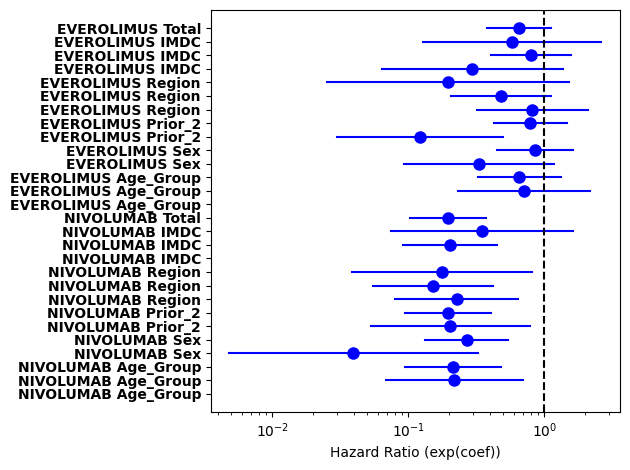

In [25]:

plot_order = plot_order_extended
plot_table = plot_table.loc[plot_order].copy()
# plot_table = plot_table.loc[['class' not in i for i in plot_table.index]]
n_ind = dict(zip(plot_order, np.arange(len(plot_table.index.unique()))))
for index, row in plot_table.iterrows():
    index_name = f'{index[0]} {index[1]}'
    # if 'class' not in index_name:
    # if any confidence interval is Inf, do not plot it
    if row['exp(coef) lower 95%'] > 0 and row['exp(coef) upper 95%'] != np.inf:
        # if any row has NIVO n <5 or EVERO n <5, do not plot it
        if row['IM+ n'] >= 4 and row['IM- n'] >= 4:
            # offset the points slightly to avoid overlap
            plt.plot(row['exp(coef)'], [n_ind[index]], 'o', color=col_to_use, markersize=8)
            plt.plot([row['exp(coef) lower 95%'], row['exp(coef) upper 95%']], [n_ind[index], n_ind[index]], marker='', markersize=8, linestyle='-', color=col_to_use)
    else:
        # plot a horizontal line at 1
        plt.plot([1, 1], [n_ind[index], n_ind[index]], marker='', markersize=8, linestyle='-', color=col_to_use)


# limit x axis to 0.25 - 4
# plt.xlim(0.1, 3)

# add vertical dashed line at 1
plt.axvline(x=1, linestyle='--', color='black')
# plt.yticks(range(len(summary_table)), summary_table.index)
plt.xscale('log')  # Use log scale for better visualization
plt.xlabel('Hazard Ratio (exp(coef))')
# plt.xticks([0.01, 0.1, 0.25, 0.5, 1, 2.5, 5], [0.01, 0.1, 0.25, 0.5, 1, 2.5, 5])

# # Adjust axis limits
# xmin, xmax, ymin, ymax = plt.axis()
# plt.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])  # Adjust the offset as needed
plt.yticks(list(n_ind.values()), [f'{index[0]} {index[1]}' for index in n_ind.keys()])
plt.yticks(fontweight='bold')
plt.tight_layout()

# # format plot_table to 3 decimal places
ptf = plot_table.round(3)
# reverse order of rows
ptf = ptf.iloc[::-1]
ptf['HR (95% CI)'] = ptf.apply(lambda x: f"{x['exp(coef)']} ({x['exp(coef) lower 95%']}, {x['exp(coef) upper 95%']})", axis=1)
# ptf[['HR (95% CI)', 'p', 'NIVO n', 'EVERO n', 'class']]
ptf_d = ptf[['HR (95% CI)', 'p','-log2(p)', 'IM+ n', 'IM- n']].to_dict(orient="index")
# for k,v in ptf.items():
#     # add text of v to plot
#     plt.text(10, n_ind[k], f"{v[('HR (95% CI)', 'All')]}")

ptf[['HR (95% CI)', 'p','-log2(p)', 'IM+ n', 'IM- n']]